In [1]:

import pandas as pd
import glob
import numpy as np
from geopy.geocoders import Nominatim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import joblib
from catboost import CatBoostRegressor
import matplotlib.pyplot as mp
import seaborn as sb
import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignore Warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

In [2]:
ht_path = "High Tension/"
lt_path = "Low Tension/"
ht_files = glob.glob(ht_path + "*.csv")
lt_files = glob.glob(lt_path + "*.csv")
ht_files.sort()
lt_files.sort()

In [3]:
year = [2018, 2019, 2020, 2021, 2022]

In [4]:
ht = []
lt = []
for i in range(len(ht_files)):
  ht.append(pd.read_csv(ht_files[i]))
  lt.append(pd.read_csv(lt_files[i]))

In [5]:
for i in range(len(ht)):
    ht[i].dropna(inplace=True)
    lt[i].dropna(inplace=True)

In [6]:
col = ['Sl. No.',
 'Divisions',
 'Overhead(OH)',
 'OH Dismantled',
 'OH Cables Total',
 'Underground(UG)',
 'UG Dismantled',
 'UG Total',
 'Ariel Bundled(AB)',
 'AB Cables Dismantled',
 'AB Cables Total',
 'Total Cable Length (km)']

In [7]:
for i in range(len(ht)):
    col_name = ht[i].columns.tolist()
    for j in range(len(col_name)):
        ht[i].rename(columns={col_name[j]: col[j]}, inplace=True)
        lt[i].rename(columns={col_name[j]: col[j]}, inplace=True)
lt[4].rename(columns={'Overhead(OH) Added for 2019-20':'Overhead(OH)'}, inplace=True)

In [8]:
for i in range(len(ht)):
    ht[i]['Year'] = year[i]
    ht[i]['Tension'] = 1
    lt[i]['Year'] = year[i]
    lt[i]['Tension'] = 0

In [9]:
final_ht = pd.concat([x for x in ht])
final_lt = pd.concat([x for x in lt])
data = pd.concat([final_ht, final_lt])

In [10]:
data.reset_index(inplace=True)
data.drop(['index', 'Sl. No.'], axis=1,inplace=True)
data['Latitude'] = np.nan
data['Longitude'] = np.nan

In [11]:
data.loc[np.where(data['Divisions'] == 'CB Pura')[0], 'Divisions'] = 'Chikkaballapura'
data.loc[np.where(data['Divisions'] == 'Ramnagara')[0], 'Divisions'] = 'Ramanagara'
data.loc[np.where(data['Divisions'] == 'Ramnagara ')[0], 'Divisions'] = 'Ramanagara'
data['Divisions'] = data['Divisions'] + ', India'

In [12]:
geolocator = Nominatim(user_agent="myApp")

In [13]:
for i in data.index:
    try:
        location = geolocator.geocode(data['Divisions'][i])
        
        data.loc[i, 'Latitude'] = location.latitude
        data.loc[i, 'Longitude'] = location.longitude
    except:
        data.loc[i, 'Latitude'] = np.nan
        data.loc[i, 'Longitude'] = np.nan

In [14]:
data[data.isna().any(axis=1)]

,Divisions,Overhead(OH),OH Dismantled,OH Cables Total,Underground(UG),UG Dismantled,UG Total,Ariel Bundled(AB),AB Cables Dismantled,AB Cables Total,Total Cable Length (km),Year,Tension,Latitude,Longitude


In [15]:
data.drop(['OH Cables Total','Divisions', 'Overhead(OH)', 'OH Dismantled','Underground(UG)','UG Dismantled', 'UG Total', 'Ariel Bundled(AB)', 'AB Cables Dismantled', 'AB Cables Total'], axis=1, inplace=True)

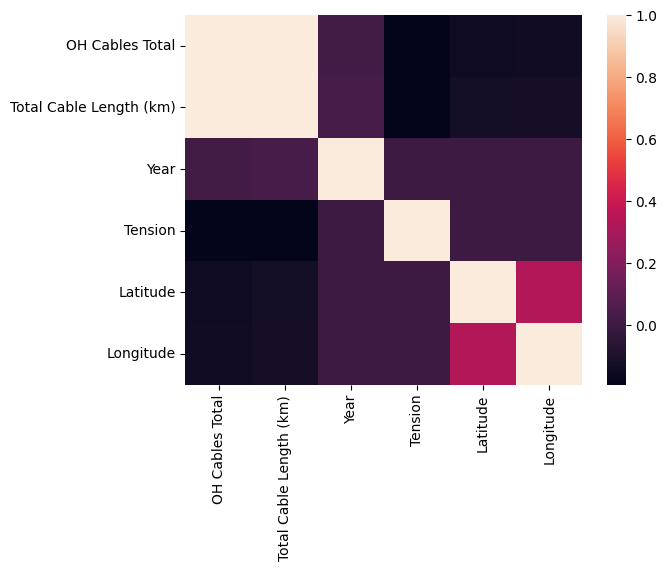

In [16]:
dataplot = sb.heatmap(data.corr())
mp.show()

In [18]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Total Cable Length (km)'], axis=1), data['Total Cable Length (km)'], test_size=0.2, random_state=42)

In [19]:
cat_model = CatBoostRegressor().fit(X_train, y_train)

Learning rate set to 0.032972
0:	learn: 4683.0010128	total: 135ms	remaining: 2m 15s
1:	learn: 4597.6571514	total: 136ms	remaining: 1m 7s
2:	learn: 4509.7577106	total: 137ms	remaining: 45.5s
3:	learn: 4439.7303436	total: 137ms	remaining: 34.2s
4:	learn: 4389.2086440	total: 138ms	remaining: 27.4s
5:	learn: 4314.4299758	total: 139ms	remaining: 23s
6:	learn: 4247.6642933	total: 139ms	remaining: 19.8s
7:	learn: 4183.9919552	total: 140ms	remaining: 17.4s
8:	learn: 4107.7080349	total: 141ms	remaining: 15.5s
9:	learn: 4036.6145829	total: 142ms	remaining: 14s
10:	learn: 3978.1074781	total: 142ms	remaining: 12.8s
11:	learn: 3903.5640617	total: 143ms	remaining: 11.8s
12:	learn: 3851.9530803	total: 144ms	remaining: 10.9s
13:	learn: 3791.7020486	total: 144ms	remaining: 10.2s
14:	learn: 3733.4511809	total: 145ms	remaining: 9.51s
15:	learn: 3678.6187867	total: 145ms	remaining: 8.94s
16:	learn: 3627.7405295	total: 146ms	remaining: 8.45s
17:	learn: 3572.3780585	total: 147ms	remaining: 8s
18:	learn: 352

In [20]:
cat_model.score(X_test, y_test)

0.9827694692586211

In [21]:
joblib.dump(cat_model, "model/Catmodel.pkl")

['model/Catmodel.pkl']